In [35]:
!pip3 install pydot

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import BatchNormalization, LeakyReLU
from tensorflow.keras.initializers import RandomNormal, Constant
from tensorflow.keras.utils import plot_model
import cv2
import os
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import pickle

In [3]:
img_height = 300
img_width = 300
batch_size = 32

In [4]:
age_set = []
gender_set = []
race_set = []
face_img_pixels_set = []
path = "./FaceRecognitionDataset"
dir_list = os.listdir(path)

for img_dir in dir_list:
    try:
        img_path = "./FaceRecognitionDataset"
        img_path += "/" + img_dir
        face_img_dir = os.listdir(img_path)
        for face_img in face_img_dir:
            if ".jpg" in face_img:
                face_img_split = face_img.split("_")
                age_set_str_int = face_img_split[0]
                age_set_str_int = int(age_set_str_int)
                age_set.append(age_set_str_int)
                gender_set_str_int = face_img_split[1]
                gender_set_str_int = int(gender_set_str_int)
                gender_set.append(gender_set_str_int)
                race_set_str_int = face_img_split[2]
                race_set_str_int = int(race_set_str_int)
                race_set.append(race_set_str_int)
                face_img_path = img_path + "/" + face_img
                face_img_pixels = cv2.imread(face_img_path)
                dim = (img_height, img_width)
                img_resize = cv2.resize(face_img_pixels, dim)
                cv2.imwrite(face_img_path, img_resize) 
                face_img_pixels_resized = cv2.imread(face_img_path)
                face_img_pixels_set.append(face_img_pixels_resized)     
    except:
        pass

FileNotFoundError: [Errno 2] No such file or directory: './FaceRecognitionDataset'

In [1]:
len(face_img_pixels_set)
face_img_pixels_set = np.stack(face_img_pixels_set)

NameError: name 'face_img_pixels_set' is not defined

In [5]:
print(face_img_pixels_set.shape)

(28663, 300, 300, 3)


In [6]:
race_set = np.array(race_set)

In [7]:
data_augmentation = keras.Sequential(
  [
    layers.RandomFlip("horizontal",
                      input_shape=(img_height,
                                  img_width,
                                  3)),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
  ]
)

2021-11-05 18:44:45.840595: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [8]:
print()

In [9]:
pixel_data_train, pixel_data_test, race_data_train, race_data_test = train_test_split(face_img_pixels_set, race_set, 
                                                                                        test_size = 0.2, random_state=123)
pixel_data_train, pixel_data_val, race_data_train, race_data_val = train_test_split(pixel_data_train, race_data_train,
                                                                                     test_size = 0.25,  random_state=123)

In [10]:
normalization_layer = layers.Rescaling(1./255)

In [45]:
num_classes = 5

model = Sequential([
  data_augmentation,
  layers.Rescaling(1./255),
  layers.Dense(12, activation='relu'),
  layers.Dropout(0.2),
  layers.Dense(8, activation='relu'),
  layers.Dropout(0.2),
  layers.Dense(1, activation='sigmoid'),
  layers.Conv2D(64, (3,3), padding='same', activation='relu'),
  layers.BatchNormalization(),
  layers.Conv2D(64, (3,3), padding='same', activation='relu'),
  layers.MaxPooling2D(pool_size=(2, 2), strides=(2,2)),
  layers.BatchNormalization(),
  layers.Conv2D(128, (3,3), padding='same', activation='relu'),
  layers.BatchNormalization(),
  layers.Conv2D(128, (3,3), padding='same', activation='relu'),
  layers.MaxPooling2D(pool_size=(2, 2), strides=(2,2)),
  layers.BatchNormalization(),
  layers.Conv2D(256, (3,3), padding='same', activation='relu'),
  layers.BatchNormalization(),
  layers.Conv2D(256, (3,3), padding='same', activation='relu'),
  layers.BatchNormalization(),
  layers.Conv2D(256, (3,3), padding='same', activation='relu'),
  layers.BatchNormalization(),
  layers.Conv2D(256, (3,3), padding='same', activation='relu'),
  layers.MaxPooling2D(pool_size=(2, 2), strides=(2,2)),
  layers.BatchNormalization(),
  layers.Conv2D(512, (3,3), padding='same', activation='relu'),
  layers.BatchNormalization(),
  layers.Conv2D(512, (3,3), padding='same', activation='relu'),
  layers.BatchNormalization(),
  layers.Conv2D(512, (3,3), padding='same', activation='relu'),
  layers.BatchNormalization(),
  layers.Conv2D(512, (3,3), padding='same', activation='relu'),
  layers.MaxPooling2D(pool_size=(2, 2), strides=(2,2)),
  layers.BatchNormalization(),
  layers.Conv2D(512, (3,3), padding='same', activation='relu'),
  layers.BatchNormalization(),
  layers.Conv2D(512, (3,3), padding='same', activation='relu'),
  layers.BatchNormalization(),
  layers.Conv2D(512, (3,3), padding='same', activation='relu'),
  layers.BatchNormalization(),
  layers.Conv2D(512, (3,3), padding='same', activation='relu'),
  layers.MaxPooling2D(pool_size=(2, 2), strides=(2,2)),
  layers.BatchNormalization(
        momentum=0.95, 
        epsilon=0.005,
        beta_initializer=RandomNormal(mean=0.0, stddev=0.05), 
        gamma_initializer=Constant(value=0.9)
  ),
  layers.Flatten(),
  layers.Dense(4096, activation='relu'),
  layers.Dropout(0.2),
  layers.Dense(4096, activation='relu'),
  layers.Dropout(0.2),
  layers.Dense(num_classes, activation='softmax')
])

In [47]:
learning_rate = 0.001
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy', 'mse', 'mae', 'mape'])

In [48]:
model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential (Sequential)      (None, 300, 300, 3)       0         
_________________________________________________________________
rescaling_10 (Rescaling)     (None, 300, 300, 3)       0         
_________________________________________________________________
conv2d_29 (Conv2D)           (None, 300, 300, 16)      448       
_________________________________________________________________
max_pooling2d_29 (MaxPooling (None, 150, 150, 16)      0         
_________________________________________________________________
batch_normalization_30 (Batc (None, 150, 150, 16)      64        
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 150, 150, 16)      0         
_________________________________________________________________
conv2d_30 (Conv2D)           (None, 150, 150, 32)     

In [49]:
plot_model(model)

('You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) ', 'for plot_model/model_to_dot to work.')


In [50]:
epochs = 5
print(pixel_data_train[2].shape)
print(pixel_data_train.shape, pixel_data_train.dtype)
X = tf.convert_to_tensor(pixel_data_train)
print(X.shape)
Y = tf.convert_to_tensor(race_data_train, dtype=tf.float32)
history = model.fit(
  x = X, y = Y,
  validation_data = (pixel_data_val, race_data_val),
  epochs=epochs
)

(300, 300, 3)
(17197, 300, 300, 3) uint8
(17197, 300, 300, 3)
Epoch 1/5
538/538 [==============================] - 1010s 2s/step - loss: 1.4179 - accuracy: 0.4304 - mse: 4.0510 - mae: 1.5365 - mape: 218767888.0000 - val_loss: 1.4067 - val_accuracy: 0.4551 - val_mse: 4.1470 - val_mae: 1.5689 - val_mape: 235126320.0000
Epoch 2/5
538/538 [==============================] - 2528s 5s/step - loss: 1.3950 - accuracy: 0.4336 - mse: 4.1169 - mae: 1.5560 - mape: 235759328.0000 - val_loss: 1.3859 - val_accuracy: 0.4474 - val_mse: 4.3612 - val_mae: 1.6152 - val_mape: 261610448.0000
Epoch 3/5
538/538 [==============================] - 955s 2s/step - loss: 1.3861 - accuracy: 0.4371 - mse: 4.1460 - mae: 1.5665 - mape: 247678992.0000 - val_loss: 1.3990 - val_accuracy: 0.4336 - val_mse: 4.1789 - val_mae: 1.5798 - val_mape: 252740288.0000
Epoch 4/5
538/538 [==============================] - 1004s 2s/step - loss: 1.3834 - accuracy: 0.4325 - mse: 4.1610 - mae: 1.5743 - mape: 257029872.0000 - val_loss: 1.39

In [15]:
print(tf.__version__)

2.6.1


In [16]:
model.save('baseline-cnn.h5')

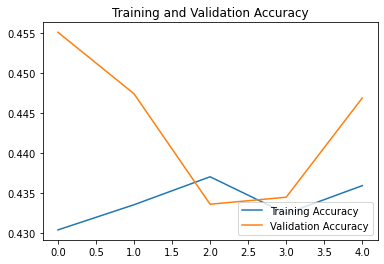

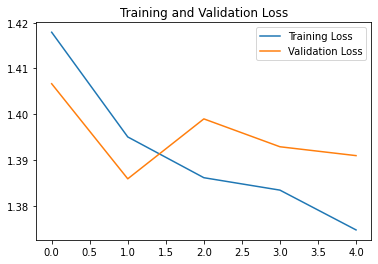

In [51]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')
plt.show()

plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [28]:
with open('pixelset.pkl', 'wb') as f:
    pickle.dump(face_img_pixels_set, f)

In [29]:
with open('raceset.pkl', 'wb') as f:
    pickle.dump(race_set, f)